In [2]:
import os

os.chdir('../../')

In [3]:
import torch
import json
import numpy as np
from rdkit import Chem
from itertools import chain
from sklearn import manifold
from fcd import get_fcd, load_ref_model,canonical_smiles, get_predictions, calculate_frechet_distance

model = load_ref_model()

/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
decomp_res_path = 'misc/evaluations/decompdiff_agg_data_evaluated.json'
with open(decomp_res_path) as f:
    decomp_res = json.load(f)
    
benchmark_res = decomp_res

In [5]:
pharmaco_res_path = 'misc/evaluations/archive/20240117_alpha_default_evaluated.json'
with open(pharmaco_res_path) as f:
    pharmaco_res = json.load(f)

In [6]:
crossdock = torch.load("dataset/archived/crossdock_docking_scores/all_crossdock_100k.pt")
crossdock_smiles = list(set([v[1] for v in crossdock]))

In [7]:
benchmark_smis = list(chain.from_iterable([v['smiles'] for _, v in benchmark_res.items()]))
benchmark_mols = [Chem.MolFromSmiles(s) for s in benchmark_smis]

In [8]:
pharmaco_smi = list(chain.from_iterable([v['smiles'] for _, v in pharmaco_res.items()]))
pharmaco_mols = [Chem.MolFromSmiles(m) for m in pharmaco_smi]
pharmaco_fps = np.array([list(Chem.RDKFingerprint(m)) for m in pharmaco_mols])

In [9]:
act0 = get_predictions(model, crossdock_smiles)
act1 = get_predictions(model, benchmark_smis)
act2 = get_predictions(model, pharmaco_smi)

In [10]:
reducer = manifold.TSNE(n_components=2, random_state=0)

In [11]:
features = reducer.fit_transform(np.vstack([act0, act1, act2]))

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fcc03e70af0>
Traceback (most recent call last):
  File "/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


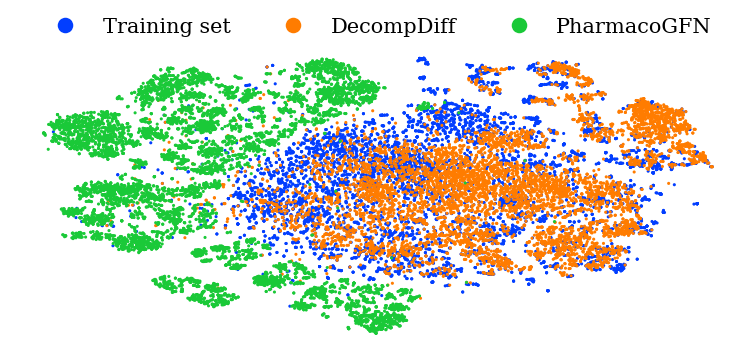

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the font to the one commonly used in ML papers
# reset to default
plt.rcParams.update(plt.rcParamsDefault)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
# plt.rcParams['font.weight'] = 'bold'

plt.figure(figsize=(8, 5))  

# name each scatter plot its source 
hues = ['Training set']*len(act0) + ['DecompDiff']*len(act1) + ['PharmacoGFN']*len(act2)

# Create the scatter plot
sns.scatterplot(x=features[:,0], y=features[:,1], hue=hues, alpha=1, palette='bright', s=5, edgecolor='none')

# Adjust legend to be 
legend = plt.legend(loc='upper center', markerscale=5, fontsize=15, ncol=3, bbox_to_anchor=(0.5, 1.15))
legend.get_frame().set_edgecolor('none')  # Remove edge color
# transparent legend background
legend.get_frame().set_facecolor('none')

plt.axis('off')

# less whitespace
plt.tight_layout(pad=0.0)

plt.subplots_adjust(bottom=0.3)  
# Save the plot as a high-quality image
plt.savefig('figures/tsne_targetdiff_pharmacogfn.png', dpi=500, bbox_inches='tight')



# Show the plot
plt.show()